<a href="https://colab.research.google.com/github/jcandane/StochasticPhysics/blob/main/gpcam_rcf(n%2C1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Task RCF($N,1$)

In [1]:
import numpy as np
import h5py
from tqdm import tqdm

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [12]:
try:
    import gpcam
    from gpcam.autonomous_experimenter import AutonomousExperimenterFvGP
except:
    !pip install gpcam
    from gpcam.autonomous_experimenter import AutonomousExperimenterFvGP

try:
    import GPy
except:
    !pip install GPy
    import GPy

try:
    from rcf_gpy import RCF
except:
    !wget https://raw.githubusercontent.com/jcandane/RCF/main/rcf_gpy.py
    from rcf_gpy import RCF

# RCF -> gpcam apparatus

In [3]:
#################################################

def gpcam_to_h5(data, filename="to_vintrumentxx.h5"):
    """ this function reads gpcam's data, and creates an h5 file (to be read by the instrument)
    GIVEN   > data : List[dict] (gpCAM dataset datatype, !contains various datatypes)
            **filename : str (optional, str specifying the output h5 file)
    GET     > None
    """

    to_analyze=[]
    for entry in data:
        to_analyze.append(entry["x_data"])
    to_analyze = np.asarray(to_analyze) ## make into a np.array, D_ax

    h5f = h5py.File(filename, "w")
    h5f.create_dataset("dataset_1", data=to_analyze)
    h5f.close()
    return None

def h5_to_vinstrument(filename="to_vintrumentxx.h5"):
    """
    this function reads a h5 file, to obtain a 2d-numpy.array (to be used by the virtual-intrument)
    GIVEN > **filename : str
    GET   > x_data : np.ndarray{2d} (D_ax, 1st-index enumerates snapshots, 2nd-index enumerates IN-coordiante, i.e. D_ax)
    """

    h5f    = h5py.File(filename, "r")
    x_data = np.asarray(h5f.get('dataset_1'))
    h5f.close()
    return x_data ### numpy.array of dimensions ( samples , coordinates ) i.e. D_ax

def vinstrument_to_h5(y_data, filename="from_vintrumentxx.h5"):
    """
    this function obtained the vintrument's y_data, along with other meta-data saves to an h5
    GIVEN > y_data : np.ndarray{2d} (2d-np.array, 1st-index : data-entry number, 2nd-index : OUT-coordinate, i.e. D_aX)
    GET >   None
    """

    h5f = h5py.File(filename, "w")
    h5f.create_dataset("dataset_1", data=y_data)
    h5f.close()
    return None

def h5_to_gpcam(data, filename="from_vintrumentxx.h5"):
    """ this function updates gpcam's "data" variable (List[dict]), by reading a h5 file.
    GIVEN > data : List[dict] (gpCAM dataset datatype, !contains various datatypes)
            **filename : str (optional, str specifying the input h5 file)
    GET   > data : List[dict] (gpCAM dataset datatype, !contains various datatypes)
    """
    h5f    = h5py.File(filename, "r")
    y_data = np.asarray(h5f["dataset_1"]) ## D_aX
    h5f.close()

    for a, entry in enumerate(data):
        entry["y_data"] = np.asarray([y_data[a]]) ### this should have the shape of (2,1) as given in instrument
        entry["output positions"] = np.asarray([np.arange(len(y_data[a]))]).T #np.array([[0],[1]]) ### this is important for fvGP object!
        #entry["output positions"] = np.asarray([np.arange(f.D)]).T

    return data

class gpcam_test_instrument():
    """
    uses RCF function to create a test instrument in gpcam, while writing h5 files
    out to interface.
    """

    def __init__(self, Domain, D=1, N=17, seed=777, kernel=None):
        self.domain = Domain ### numpy.2darray
        self.D      = D      ### int (dimension of OUT)
        self.N      = N
        self.seed   = seed
        self.rcf    = RCF(self.domain, N=self.N, MO=self.D, seed=self.seed)

    #################################
    def vinstrument(self):
        """ python-function for virtual-instrument, reads and writes h5 files
        GIVEN > None
        GET   > None
        """

        x_data = h5_to_vinstrument()

        y_data = self.rcf(x_data)

        vinstrument_to_h5(y_data)

        return None

    def __call__(self, data):

        ### gpcam -> h5 (x-coordinates only)
        gpcam_to_h5(data)

        ### vintrument()
        self.vinstrument()

        ### h5 -> gpcam (everything)
        data = h5_to_gpcam(data)

        return data
    #################################

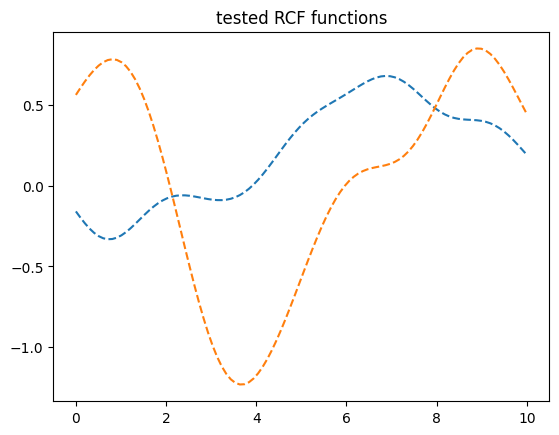

In [4]:
input_space         = np.array([[ 0.0, 10.0]])
number_of_functions = 2

apparatuses = [ gpcam_test_instrument(input_space, 1, seed=i) for i in range(number_of_functions) ]

xs = np.linspace(input_space[0,0], input_space[0,1], 100)
ys = np.asarray([ f.rcf(xs.reshape(-1,1)).reshape(-1) for f in apparatuses ]).T

plt.plot(xs, ys, linestyle="dashed")
plt.title("tested RCF functions")
plt.show()

# Acqusition Functions used

In [5]:
#available 12 acquisition functions:
acquisition_functions = ["variance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "probability of improvement", "target probability", "total correlation"]

In [6]:
data_out=[]
for f in apparatuses:
    acq_data_out=[]
    for Acquisition_function in tqdm(acquisition_functions):
        my_experiment = AutonomousExperimenterFvGP(f.domain,
                                                    f.D, 1,
                                                    init_dataset_size=10,
                                                    instrument_function=f,
                                                    acquisition_function=Acquisition_function)
        my_experiment.train()
        my_experiment.go(10)

        acq_data_out.append( np.concatenate([my_experiment.x_data, my_experiment.y_data], axis=1) )
    data_out.append(acq_data_out)

data_outt = np.asarray( data_out )
data_outt = data_outt.swapaxes(2,3)
data_outt.shape ## (instruments, acquisition-functions, coordinate, data-points)

  0%|          | 0/12 [00:00<?, ?it/s] /usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:280: UserWarning:Hyperparameter bounds have been initialized automatically                     
 for the default kernel in fvgp. They will automatically used for the training.                    
 However, you can also define and provide new bounds.
 /usr/local/lib/python3.10/dist-packages/fvgp/fvgp.py:287: UserWarning:No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).
100%|██████████| 12/12 [02:24<00:00, 12.01s/it]


(2, 12, 2, 10)

# Plot

In [7]:
fig = make_subplots(
    rows=data_outt.shape[0], cols=data_outt.shape[1],
    subplot_titles=(2*acquisition_functions))

for apparatus in range(len(apparatuses)):
    for acq_fun in range(len(acquisition_functions)):
        fig.add_trace(go.Line(x=xs, y=ys[:,apparatus]), row=(apparatus+1), col=(acq_fun+1)) #, mode="markers"
        fig.add_trace(go.Scatter(x=data_outt[apparatus,acq_fun,0,:], y=data_outt[apparatus,acq_fun,1,:], mode="markers", marker = {'color' : 'black'}), row=(apparatus+1), col=(acq_fun+1))

fig.update_layout(height=500, width=3700, title_text="Acquisition Functions test")
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# higher dimensional functions (higher $N$, input dimension)

### cannot plot :( (dimension is too high)

In [18]:
#available 12 acquisition functions:
acquisition_functions = ["variance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "probability of improvement", "target probability", "total correlation"]

In [19]:
input_spaces = [ np.array([[-19, -8.]]), np.array([[ 0.0, 10.0], [0., 17.]]), np.array([[ 0.0, 10.0], [0., 17.], [-19, -8.]]), np.array([[ 0.0, 10.0], [0., 17.], [-5, 8.], [-19, -8.]]) ]

apparatuses = [ gpcam_test_instrument(input_spaces[i], 1, seed=i) for i in range(len(input_spaces)) ]

In [20]:
data_out=[]
for f in tqdm(apparatuses):
    my_experiment = AutonomousExperimenterFvGP(f.domain,
                                                f.D, 1,
                                                init_dataset_size=10,
                                                instrument_function=f)
                                                #acquisition_function=Acquisition_function)
    my_experiment.train()
    my_experiment.go(15)

    data_out.append( np.concatenate([my_experiment.x_data, my_experiment.y_data], axis=1).swapaxes(0,1) )

print( [element.shape for element in data_out ] ) ## (instruments, acquisition-functions, coordinate, data-points)

100%|██████████| 4/4 [01:11<00:00, 17.96s/it]

[(2, 15), (3, 15), (4, 15), (5, 15)]


# higher dimensional functions (e.g. RCF($4,7$))

### cannot plot :( (dimension is too high)

In [10]:
input_space         = np.array([[ 0.0, 10.0], [0., 17.], [-5, 8.], [-19, -8.]])
number_of_functions = 2

apparatuses = [ gpcam_test_instrument(input_space, 7, seed=i) for i in range(number_of_functions) ]

In [11]:
acquisition_functions = ["variance","relative information entropy","relative information entropy set","ucb"]

data_out=[]
for f in apparatuses:
    acq_data_out=[]
    for Acquisition_function in tqdm(acquisition_functions):
        my_experiment = AutonomousExperimenterFvGP(f.domain,
                                                    f.D, 1,
                                                    init_dataset_size=10,
                                                    instrument_function=f,
                                                    acquisition_function=Acquisition_function)
        my_experiment.train()
        my_experiment.go(15)

        acq_data_out.append( np.concatenate([my_experiment.x_data, my_experiment.y_data], axis=1) )
    data_out.append(acq_data_out)

data_outt = np.asarray( data_out )
data_outt = data_outt.swapaxes(2,3)
data_outt.shape ## (instruments, acquisition-functions, coordinate, data-points)

100%|██████████| 4/4 [05:58<00:00, 89.70s/it]


(2, 4, 11, 15)